# Classification Predict - Climate Change

![eco-friendly.jpg](eco-friendly.jpg)

## Table of contents

1. [Problem identification](#the_problem)  


2. [What data do we have?](#the_data)  
    2.1. [Install necessary packages](#install)  
    2.2. [Start experiment](#exps)  
    2.3. [Import the libraries](#imp_lib)  
    2.4. [Import the dataset](#imp_data)  
    
    
3. [Exploratory data analysis](#the_analysis)   
    
    
4. [Preprocessing](#the_prep)  
    4.1. [Data cleaning](#clean)  
    4.2. [Split data into response and predictors](#split1)  
    4.3. [Split data into training and validation sets](#split2)    
    
    
5. [Build pipelines for feature extraction](#vect)  
    5.1. [Vectorize](#v)  
    5.2. [Stem](#s)  
    5.3. [Tokenization](#t)  
    5.4. [Remove stopwords](#rs)  
    5.5. [Hyperparameter optimization](#optimize)


6. [Train models](#train)  


7. [Make predictions](#pred)  


8. [Evaluate model accuracy](#the_eval)  
    8.1. [Confusion matrices](#mat)  
    8.2. [Classification report](#report)  


9. [Saving important data](#sav)  
    9.1. [Save the model](#mod)  
    9.2. [Save the graphs](#graph)


10. [Log parameters](#log)  


11. [Conclusion](#the_conclusion)


## Problem identification

#### Background

In a [research article](https://www.barrons.com/articles/two-thirds-of-north-americans-prefer-eco-friendly-brands-study-finds-51578661728) conducted, 19,000 customers from 28 countries where given a poll to find out how individual shopping decisions are changing. Nearly 70% of consumers in the U.S. and Canada find that it is important for a company or brand to be sustainable or eco-friendly. More than a third (40%) of the respondents globally said that they are purpose-driven consumers, who select brands based on how well they align with their personal beliefs.

Many companies are built around lessening their environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

#### Problem statement

Build a machine learning model that is able to classify whether or not an individual believes in man-made climate change based on historical tweet to increase insights about customers and inform future marketing strategies.

You can find the project overview [here](https://www.kaggle.com/c/climate-change-belief-analysis/overview).

## What data do we have?

The dataset that will be used in this classification project aggregates tweets pertaining to climate change, collected between Apr 27, 2015 and Feb 21, 2018. In total, 15819 tweets are used in the dataset. The data consists of 3 columns; tweetid, sentiment and message. A description of each column in the data is given below

**Variable definitions**

| **Variable** | **Description**   |
|:------------:|:------------------|
|**tweetid**   | Twitter unique ID |
|**message**   | Tweet body        |
|**sentiment** | Sentiment of tweet|

 Each tweet is labelled as one of the following classes:

| **Class** | **Tag** | **Description** |
|:---------:|:----------------:|:----------------|
|   **2**   | **News** |The tweet links to factual news about climate change |
|   **1**   | **Pro** |The tweet supports the belief of man-made climate change |
|   **0**   | **Neutral** |The tweet neither supports nor refutes the belief of man-made climate change |
|  **-1**   | **Anti** |The tweet does not believe in man-made climate change |

In [ ]:
!pip install comet_ml
!pip install seaborn
!pip install wordcloud
!pip install emoji
!pip install pyspellchecker
!pip install ftfy

### Start experiment

In [ ]:
# from comet_ml import Experiment

In [ ]:
# Setting the API key (saved as environment variable)
# experiment = Experiment(api_key="upOwchWrd7H1e6VEnWKW7PSvz", project_name="classification-predict", workspace="team-rm1")

## 1. Importing packages

This notebook requires some packages that may not be installed on your local machine. Below we provide a list of packages to be installed (if they are not yet installed) and the code to install them.  

Run the following commands within Git bash (Windows), terminal (Mac/Linux) or inside your Anaconda Prompt.

- Comet_ml - `pip install comet_ml==3.1.9`  
- Seaborn - `pip install seaborn==0.9.0`  
- Wordcloud - `pip install wordcloud==1.7.0`  
- Emoji - `pip install emoji==0.5.4`  
- Pyspellchecker - `pip install pyspellchecker==0.5.4`  
- Ftfy - `pip install ftfy==5.7`  
- PyLDAvis - `pip install pyldavis==2.1.2`  
- Gensim - `pip install gensim==`

In [168]:
# Packages for data analysis
import numpy as np
import pandas as pd

# Packages for visualisations
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Packages for preprocessing
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
import emoji
from ftfy import fix_text
from spellchecker import SpellChecker 
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import itertools
from sklearn.model_selection import train_test_split

# Packages for training models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Packages for hyperparameter optimisation
from sklearn.model_selection import GridSearchCV

# Packages for evaluating model accuracy
from sklearn.metrics import f1_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Packages for saving models
import pickle

## 2. Importing the data

In [2]:
df_test = pd.read_csv('https://raw.githubusercontent.com/Amogelang20/RM1_classification_predict/dev/test.csv')
df_train = pd.read_csv('https://raw.githubusercontent.com/Amogelang20/RM1_classification_predict/dev/train.csv')

In [3]:
# Import training dataset
df_train.set_index('tweetid',inplace = True)

In [4]:
# Import testing dataset
df_test.set_index('tweetid',inplace = True)

In [5]:
df_train_eda=df_train.copy()

## Preprocessing

### Data cleaning

The `message` column is currently in its raw form and needs to be cleaned for the model to be able to better process, analyze and provide predictions for sentiments. Before we start cleaning, we'll extract some extra features that could possibly improve our model's predicting accuracy.

**Extra feature extraction**

The first feature we will extract is the sentiment of a tweet. We determine the sentiment of a tweet by using python's VADER library. This feature could be useful since we would expect tweets classified as `Anti` to have a more negative tone than tweets classified as `Pro`. We'll start by writing a function that takes a text string as input and determines its sentiment, i.e. negative, positive or neutral. Since these tweets do not have a wide range when it comes to sentiment scores (rarely more than 0.4) we decided to classify all tweets with scores of less than -0.05 as negative, scores between -0.05 and 0.05 where classified as neutral and a score of more than 0.05 indicated a positive tweet.

In [6]:
# Function to extract sentiment
def sentiment_score(text):
    """ A function that determines the sentiment of a text string.

        Parameters
        ----------
        text: Text string.

        Returns
        -------
        sentiment:  String indicating the sentiment of the input string.
    """
    
    sid = SentimentIntensityAnalyzer()
    s = sid.polarity_scores(text)['compound']
    if s<-0.05:
        sentiment='negative'
    elif s>0.05:
        sentiment='positive'
    else:
        sentiment='neutral'
    
    return sentiment

Twitter handles could be a second useful feature. Sentiment will help us a lot with classifying classes like `Anti`, `Neutral` and `Pro`, but we would find it more difficult to classify `News` using these sentiments. Twitter handles could help the model distinguish between the `News` class and the other classes. We assume that tweets classified as `News` would've probably been extracted from news accounts and therefore have news related handles.  

We now extract all **unique** Twitter handles found in tweets within the `News` class.

In [7]:
# Extract all unique news related handles into a list
df_temp = df_train.copy()
df_temp.sort_index(inplace=True)
n_temp = [re.findall(r'@[\w]+',df_temp['message'].iloc[i]) for i,x in enumerate(df_temp['sentiment']) if x==2]
news = [x for x in n_temp if x!=[]]
news = sorted(list(set(itertools.chain.from_iterable(news))))

In [8]:
# Export list of unique news related handles
with open('news_file.pkl', 'wb') as file:
    pickle.dump(news, file)

In [9]:
print(f'First 5 entries: {news[:5]} \nLast 5 entries: {news[-5:]}')

First 5 entries: ['@02Cents0', '@100isNow', '@1306Chomley', '@1o5CleanEnergy', '@233liveOnline'] 
Last 5 entries: ['@yceek', '@yearsofliving', '@yicaichina', '@zsstevens', '@Ã']


Looking at the first and last 5 entries inside our list we see our hunch was correct. We can see news channels like `@233liveOnline` and organizations like `@100isNow` (better known as "The Solutions Project") that has made it clear that their goal is to radically transform how people understand climate change and the role we all can play to solve it. There are also handles from influential people like `@zsstevens` (Stewart Stevenson), former Scottish Minister for Environment and Climate Change from, and is currently still part o fthe Environment, Climate Change and Land Reform Committee for the Scottish Parliament.  

We have now created our features and move on to cleaning the text data.

**Hashtags**

`#Hashtags` are used to make a statement about something, or to start a conversation around a specific topic or trend. In twitter data a lot of hashtags are generally used and may contain viable information that indicate a certain sentiment towards a specific topic. However, hashtags are a compressed set of words or sentences and since they are recorded as 1 word it may be hard for the model to decipher them. For this reason a dictionary,`hashtags`, has been created. This dictionary contains all the possible hashtags about climate change along with their corresponding decompressed words.

We start by extracting all unique hashtags from the training dataset and export them into two seperate .PKL files. One will be used for the keys in the dictionary and the other will be used for values (separated words). _These files are then modified further outside the jupyter notebook._ 

*Below we show the code that was used to extract and export all unique hashtags. This is merely for illustration of the process taken.*

***

`hashtags = df_train['message'].apply(lambda x: re.findall(r'[#]\\w+',x))`  

**Extracting all unique hashtags**  
`hashtags = list(set([item for sublist in hashtags for item in sublist])) `  

**Exporting twice. One is used for the keys in the dictionary and the other is used for values(separated words).**  
`with open('hash_file', 'wb') as fp:`  
`    pickle.dump(hashtags, fp)`  
`with open('hash_file_clean', 'wb') as fp:`  
`    pickle.dump(itemlist, fp)`  
***

After modifying those files we will load them back into the notebook to help with preprocessing the text data.

In [10]:
# Read in created hashtag text file and create a hashtags dictionary

# Keys
hash_file = [line.rstrip('\n') for line in open('hash_file.txt')]
hash_file = [i.center(len(i)+2) for i in hash_file]

# Values
hash_file_clean = [line.rstrip('\n') for line in open('hash_file_clean.txt')] 
hash_file_clean = [i.center(len(i)+2) for i in hash_file_clean]

hashtags = {hash_file[i]: hash_file_clean[i] for i in range(len(hash_file))} 
hashtags.update({'todayinmaker ':'today in maker'})#this is added to differentiate it from ' todayinmaker ' because this 1 occurs at start of tweet

Next we write a function to expand hashtags inside the text data into seperate words.

In [11]:
# Substitute hastags with separated words
def expand_hashtags(df,column_name):
    """ A funtion that expands the hashtag words into separate words.

        Parameters
        ----------
        df:          Dataframe containing the text column to be transformed.
        column_name: Name of the column containing the text data.

        Returns
        -------
        df:  Dataframe containg the updated text column
        
        Example
        -------
        #iamgreat returns 'i am great'
    """
    
    df[column_name] = df[column_name].str.lower()
    df[column_name] = df[column_name].apply(lambda x: re.sub(r"[#]",'',x))
    for word in hashtags.keys():
            df[column_name] = df[column_name].apply(lambda x: re.sub(word,hashtags[word]+' ',x))
    return df

In [12]:
df_train = expand_hashtags(df_train,'message')

**Contractions**

The `message` column contains some contracted words such as *can't* and *don't*. As part of the cleaning process these words will be replaced with their expanded words that do not contain any omission. We do this because we will need to tokenize the text later on. We assume that a model would have an easier time using tokens like `can` and `not` than `can` and `'t`. To help with this transformation, a dictionary `contractions` is created, that contain possible contractions and their corresponding full words.

In [13]:
# Dictionary of contracted words
contractions = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"wasn't": "was not",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we'll":"we will",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
}

In [14]:
# Export dictionary of contractions
with open('contractions_dict.pkl', 'wb') as file:
    pickle.dump(contractions, file)

Now let's replace the contracted words by their expanded alternatives.

In [15]:
# Replace contracted words with full word
df_train['message'] = [' '.join([contractions[w.lower()] if w.lower() in contractions.keys() else w for w in raw.split()]) for raw in df_train['message']]


**Lowercase**

To help our model, we will be converting all text to lowercase. We work with lower cased data to remove the noise from capitalised words. This is due to the computer seeing uppercased words as different from lower cased words. If this transformation is not applied we run the risk of the model possibly classifying cases like `Snowball` and `snowball` differently. By transforming we help the model understand that those two words are in fact the same.

In [16]:
# Lower case all words to remove noise from Capital words. Capital words may be seen as different from lower case words
df_train['message'] = df_train['message'].str.lower()


**Encoding**

Tweet data can also include bad unicode. For example, where a person wants so say `José Florés` or use a `(—)`, it ends up being `JosÃ© Florés` or `â€”` instead. These issues can make it hard for the model to process the data. There is a package in python that takes care of these issues for us. The ftfy(fixed this for you) package takes all the bad unicode and outputs the good unicode. So let's let the package fix these problems for us.

In [17]:
df_train['message'] = df_train['message'].apply(lambda x: fix_text(x))


**URLs**

We will also not be using any urls. Since urls tend to be unique and random for any class, they do not really add explanatory power and will therefore be removed.

In [18]:
# Removing urls
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'https\S+','url',x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'www\S+', 'url',x))


**Emojis**

The `message` column may also contain emojis, ex. 👨🏽‍💻. As we can see, alone they're just symbols and don't have a word association to them. This makes them hard to interpret and also makes them useless to our model. But emojis could potentially be useful in the modeling process. So instead of removing them, we'll be replacing them with the word that describes them.

In [19]:
# Replace emojis with their word meaning
df_train['message'] = df_train['message'].apply(lambda x: emoji.demojize(x))


**Shortened words/Slang**

With tweets data a lot of shortened words like *abt* are used instead of the full words *about*. This can make it difficult for the model to process these words. We will replace the shortened words with their corresponding full word. To help with this transformation, a dictionary of possible shortened words and their corresponding full words is given below.

In [20]:
# Replace shortened words with full words
short = {' BD ': ' Big Deal ',
 ' abt ':' about ',
 ' ab ': ' about ',
 ' fav ': ' favourite ',
 ' fab ': ' fabulous ',
 ' smh ': ' shaking my head ',
 ' u ': ' you ',
 ' c ': ' see ',
 ' anon ': ' anonymous ',
 ' ac ': ' aircon ',
 ' a/c ': ' aircon ',
 ' yo ':' year old ',
 ' n ':' and ',
 ' nd ':' and ',
 ' 2 ': ' to ',
 ' w ': ' with ',
 ' w/o ': ' without ',
 ' r ': ' are ',
 ' rip ':' rest in peace ',
 ' 4 ' : ' for ',
' BF ': ' Boyfriend ',
' BRB ': ' Be Right Back ',
' BTW ': ' By The Way ',
' GF ': ' Girlfriend ',
' HBD ': ' Happy Birthday ',
' JK ': ' Just Kidding ',
' K ':' Okay ',
' LMK ': ' Let Me Know ',
' LOL ': ' Laugh Out Loud ',
' HA ':' laugh ',
' MYOB ': ' Mind Your Own Business ',
' NBD ': ' No Big Deal ',
' NVM ': ' Nevermind ',
' Obv ':' Obviously ',
' Obvi ':' Obviously ',
' OMG ': ' Oh My God ',
' Pls ': ' Please ',
' Plz ': ' Please ',
' Q ': ' Question ', 
' QQ ': ' Quick Question ',
' RLY ': ' Really ',
' SRLSY ': ' Seriously ',
' TMI ': ' Too Much Information ',
' TY ': ' Thank You, ',
' TYVM ': ' Thank You Very Much ',
' YW ': ' You are Welcome ',
' FOMO ': ' Fear Of Missing Out ',
' FTFY ': ' Fixed This For You ',
' FTW ': ' For The Win ',
' FYA ': ' For Your Amusement ',
' FYE ': ' For Your Entertainment ',
' GTI ': ' Going Through It ',
' HTH ': ' Here to Help ',
' IRL ': ' In Real Life ',
' ICYMI ': ' In Case You Missed It ',
' ICYWW ': ' In Case You Were Wondering ',
' NBC ': ' Nobody Cares Though ',
' NTW ': ' Not To Worry ',
' OTD ': ' Of The Day ',
' OOTD ': ' Outfit Of The Day ',
' QOTD ': ' Quote of the Day ',
' FOTD ': ' Find Of the Day ',
' POIDH ': ' Pictures Or It Did ntt Happen ',
' YOLO ': ' You Only Live Once ',
' AFAIK ': ' As Far As I Know ',
' DGYF ': ' Dang Girl You Fine ',
' FWIW ': ' For What It is Worth ',
' IDC ': ' I Do not Care ',
' IDK ': ' I Do not Know ',
' IIRC ': ' If I Remember Correctly ',
' IMHO ': ' In My Honest Opinion ',
' IMO ': ' In My Opinion ',
' Jelly ': ' Jealous ',
' Jellz ': ' Jealous ',
' JSYK ': ' Just So You Know ',
' LMAO ': ' Laughing My Ass Off ',
' LMFAO ': ' Laughing My Fucking Ass Off ',
' NTS ': ' Note to Self ',
' ROFL ': ' Rolling On the Floor Laughing ',
' ROFLMAO ': ' Rolling On the Floor Laughing My Ass Off ',
' SMH ': ' Shaking My Head ',
' TBH ': ' To Be Honest ',
' TL;DR ':  ' Too Long; Did not Read ',
' TLDR ':  ' Too Long; Did not Read ',
' YGTR ': ' You Got That Right ',
' AYKMWTS ': ' Are You Kidding Me With This Shit ',
' BAMF ': ' Bad Ass Mother Fucker ',
' FFS ': ' For Fuck Sake ',
' FML ': ' Fuck My Life ',
' HYFR ': ' Hell Yeah Fucking Right ',
' IDGAF ': ' I Do not Give A Fuck ',
' NFW ': ' No Fucking Way ',
' PITA ': ' Pain In The Ass ',
' POS ': ' Piece of Shit ',
' SOL ': ' Shit Outta Luck ',
' STFU ': ' Shut the Fuck Up ',
' TF ': ' The Fuck ',
' WTF ': ' What The Fuck ',
' BFN ': ' Bye For Now ',
' CU ': ' See You ',
' IC ': ' I see ',
' CYL ': ' See You Later ',
' GTG ': ' Got to Go ',
' OMW ': ' On My Way ',
' RN ': ' Right Now ',
' TTYL ': ' Talk To You Later ',
' TYT ': ' Take Your time ',
' CC ': ' Carbon Copy ',
' CX ': ' Correction ',
' DM ': ' Direct Message ',
' FB ': ' Facebook ',
' FBF ': ' Flash-Back Friday ',
' FF ': ' Follow Friday ',
' HT ': ' Tipping my hat ',
' H/T ': ' Tipping my hat ',
' IG ': ' Instagram ',
' Insta ': ' Instagram ',
' MT ':' Modified Tweet ',
' OH ': ' Overheard ',
' PRT ': ' Partial Retweet ',
' RT ': ' Retweet ',
'rt ' : ' retweet ',
' SO ':' Shout Out ',
' S/O ': ' Shout Out ',
' TBT ': ' Throw-Back Thursday ',
' AWOL ': ' Away While Online ',
' BFF ': ' Best Friend Forever ',
' NSFW ': ' Not Safe For Work ',
' OG ': ' Original Gangster ',
' PSA ': ' Public Service Announcement ',
' PDA ': ' Public Display of Affection '}

short = dict((key.lower(), value.lower()) for key,value in short.items())

In [21]:
# Export dictionary of slang words
with open('short_dict.pkl', 'wb') as file:
    pickle.dump(short, file)

Now let's replace the shortened words by their full alternatives.

In [22]:
# Replacing shortened words with full words
for word in short.keys():
    df_train['message'] = df_train['message'].apply(lambda x: re.sub(word,short[word],x))


**News handles**

Here is where we will now use our first created feature. We hope that by removing all handles that are **not** news related, we are helping the model distinguish between news and non news tweets. Where news related handles can be found inside our `news` list we created earlier.

In [23]:
# Remove twitter non news related handles and @ symbol
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'@','', ' '.join([y for y in x.split() if y not in [z for z in re.findall(r'@[\w]*',x) if z not in news]])))


**Sentiment**

And now we will use the second feature we created. As explained earlier, we hope that by adding sentiment words (`negative`,`positive`,`neutral`) to the text, we are helping the model distinguish between the classes `Anti`, `Pro` and `Neutral`. We apply this transformation before removing punctuation, since punctuation like exclamation marks (`!`) are of great value during sentiment analysis. Depending on the computer you have the code below might take a minute to run.

In [24]:
# Add sentiment
df_train['message'] = df_train['message'].apply(lambda x: x + ' ' + sentiment_score(x))  

**Punctuation**

Other than with sentiment analysis, where some punctuation is useful, punctuations, symbols and numbers tend to be rendered useless in modeling. As they are not specific to certain classes, they add no explanatory power and can therefore be removed.

In [25]:
# Remove punctuation
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r"[^A-Za-z ]*",'',x))


**Vowels repeated at least 3 times**

It is not uncommon for people to stretch words when typing. For example, instead of using `cool` the word is stretched to `cooooool`. Words are of no use to us in this form, so we wish to shrink them back to their appropriate size. We'll do this by removing any extra vowels that are repeated at least three times. Note that we are aware that words like `nooooo` should be reduced to only one vowel to result in `no`. The reason we reduce to two vowels is to reduce the probability of creating misspelled words that could mean something else in their transformed form. A good example would be `beeeee`. Where `bee` and `be` would mean two completely different things.

In [26]:
# Remove vowels repeated at least 3 times ex. Coooool > Cool
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'([aeiou])\1+', r'\1\1', x))


**Sequences indicating laughing**

It is also very common for people to express laughter in different ways. A few of these ways are in fact just a sequence of repeating letters like `haha` or `lolol`. For these sequences to add more value to our model we'll change them to the word `laugh`, which the model can easily understand.

In [27]:
# Replace sequence of 'h' and 'a', as well as 'lol' with 'laugh'
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r' ha([ha]) *', r'laugh', x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r' he([he]) *', r'laugh', x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r' lol([ol]) *', r'laugh', x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r' lo([o])*l ', r'laugh', x))

**Cleaning function**

Tweets can have a lot of noise in them from the type of language, style and grammar used. All things the computer may find hard to process. These issues have to be dealt with in order for the model to be able to process the text data and make predictions. We'll write a function (`cleanup`) to apply all the necessary transformations that we applied and explained above.

In [28]:
def cleanup(raw):
    """ A function that 'cleans' tweet data. The text gets modified by:
        - being lower cased, 
        - removing urls, 
        - removing bad unicode,
        - replacing emojis with words,
        - removing twitter non news related handles,
        - removing punctuation,
        - removing vowels repeated at least 3 times,
        - replacing sequences of 'h' and 'a', as well as 'lol' with 'laugh',
        - adding sentiment

        Parameters
        ----------
        raw: Text string.

        Returns
        -------
        raw:  Modified clean string
    """
    
    # Convert to lowercase
    raw = raw.lower()
    
    # Fix strange characters
    raw = fix_text(raw)
    
    # Removing urls
    raw = re.sub(r'https\S+','url',raw)
    raw = re.sub(r'www\S+', 'url',raw)
    
    # Replace emojis with their word meaning
    raw = emoji.demojize(raw)

    # Remove twitter non news related handles
    raw = ' '.join([y for y in raw.split() if y not in [x for x in re.findall(r'@[\w]*',raw) if x not in news]])
    
    # Add sentiment
    raw = raw + ' ' + sentiment_score(raw)
    
    # Remove punctuation
    raw = re.sub(r"[^A-Za-z ]*",'',raw)
    
    # Remove vowels repeated at least 3 times ex. Coooool > Cool
    raw = re.sub(r'([aeiou])\1+', r'\1\1', raw)
    
    # Replace sequence of 'h' and 'a', as well as 'lol' with 'laugh'
    raw = re.sub(r' ha([ha]) *', r'laugh', raw)
    raw = re.sub(r' he([he]) *', r'laugh', raw)
    raw = re.sub(r' lol([ol]) *', r'laugh', raw)
    raw = re.sub(r' lo([o])*l ', r'laugh', raw)
    
    return raw


To be able to make somewhat accurate predictions we need to apply all the above transformations to our testing set `df_test` as well.

In [29]:
# Seperate hashtags
df_test = expand_hashtags(df_test,'message')

In [30]:
# Replace contracted words with full word
df_test['message'] = [' '.join([contractions[w.lower()] if w.lower() in contractions.keys() else w for w in raw.split()]) for raw in df_test['message']]


In [31]:
# Replacing shortened words with full words
for word in short.keys():
    df_test['message'] = df_test['message'].apply(lambda x: re.sub(word,short[word],x))


In [32]:
# Apply cleaning function
df_test['message'] = df_test['message'].apply(lambda x: cleanup(x))


**Spelling**

We also check the percentage of misspelled words in the data, so we can know if this is also an issue that needs to be fixed.

In [33]:
spell = SpellChecker() 
# check for misspelled words
misspelled = df_train['message'].apply(lambda x: spell.unknown(x))
misspelled.isnull().mean()

0.0

Seems like we do not have misspelled words after cleaning.  

*Great!* We've finished cleaning our data. We can now move on to exploring the data, splitting the data and training our models.

## Exploratory data analysis

Let's first get quick overview of the dataset we will be working with throughout the notebook. Below is the shape of the dataset, a list of all columns with their data types and the number of non-null values present in each column.

In [34]:
# Data shape
print('train data:',df_train.shape)

train data: (15819, 2)


In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15819 entries, 625221 to 806319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
dtypes: int64(1), object(1)
memory usage: 309.0+ KB


There are only two columns present in the training dataset; the label variable we want to classify to (`'sentiment'`), and the feature we will use to make this classification (`'message'`). We initially had a third column (`'tweetid'`) but set this column to be the index of the dataset.  The dataset contains no null entries, and the data types for (`'sentiment'`) and (`'message'`) are integer and object respectively. 

**Missing values**  

If we look at the output above, we can see that there does not seem to be any missing values present. The dataset has **15819** entries and both columns have the same amount of non-null entries. But since an empty string for tweets can also be considered as a missing entry, we need to check for empty strings in the `message` column as well.

In [36]:
# Checking for empty strings
blanks = [i for i,lb,tweet in df_train.itertuples() if type(tweet) == str if tweet.isspace()]
blanks

[]

The list is empty, indicating that there are no empty strings and therefore no missing values present in the dataset.  


**Duplicates**  

Another thing we need to look out for are duplicates. A large amount of duplicates in the data tend to increase the bias of the estimated coefficients and standard errors of the model.

In [37]:
# Checking for duplicates in tweets
df_train[df_train.duplicated(subset='message') == True].count()/len(df_train)*100

sentiment    12.548202
message      12.548202
dtype: float64

Roughly 12% of the tweets seem to be duplicated tweets but with different ID's. Since we don't have a significantly large amount of data we will keep these duplicates and later check the impact they have when fitting the models.   

[VADER](https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f) (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in text data. It provides sentiment scores based on words used ("completely" boosts a score, while "slightly" reduces it), on capitalization & punctuation ("GREAT!!!" is stronger than "great.")

Next we will analyse our text data using the `Vader` sentiment analysis polarity score, to get a view of our negative,neutral and positive tweets before we perform any analysis. We use the compound score output of vader, which is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).
Note: We will be working on a copy of the train dataset to preserve it from the modifications done to it during this exploratory data analysis process

In [108]:
sid = SentimentIntensityAnalyzer()
df_sent = df_train_eda.copy()
df_sent['compound']  =  df_sent['message'].apply(lambda x: sid.polarity_scores(x)['compound'])
df_sent['comp_score'] = df_sent['compound'].apply(lambda c: 'pos' if c >0 else 'neg' if c<0 else 'neu')
df_news = df_sent[df_sent['sentiment']==2] #extract all news and separate them from positive,neut and neg
df_analyse = df_analyse[df_analyse['sentiment'] != 2]
df_analyse.head()

,sentiment,message,compound,comp_score
tweetid,,,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...,0.2244,pos
126103,1,It's not like we lack evidence of anthropogeni...,0.1159,pos
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,-0.5994,neg
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",-0.7506,neg
425577,1,Worth a read whether you do or don't believe i...,0.2263,pos


Lets look at the 5 most positive tweets(i.e Pro: Believes in man-made climate change)

In [39]:
print('\033[1m 5 random tweets with the highest positive sentiment: \033[0m \n')
tweets = df_analyse.loc[df_analyse['compound'] > 0.8, ['message']].sample(5).values
for c in tweets:
    print(c[0])
    print('\n')

 5 random tweets with the highest positive sentiment:  

RT @BarryGardiner: Had a great evening talking with Harrogate CLP about climate change &amp; zero carbon
Then found this great gif explain… 


RT @earthhour: Check out this stunning #EarthHour shot from our friends over at Bolivia! Thank you for changing climate change wit…


hey guys climate change is real but i'm going to make fun of people who try to make it better https://t.co/O3QlxFEALO


Prof Michael Mann giving a lecture on climate change @Georgetown great honor to have him #climatechange https://t.co/814LpGY6wj


My name charity, you can let me have the 5% of the value of this, for the sake of world peace and climate change ������ https://t.co/lobDsxbIEi




Lets look at the 5 most negative tweets(i.e Anti: Does not believe in man-made climate change)

In [40]:
print('\033[1m 5 random tweets with the highest negative sentiment: \033[0m \n')
tweets = df_analyse.loc[df_analyse['compound'] < -0.8, ['message']].sample(5).values
for c in tweets:
    print(c[0])
    print('\n')

 5 random tweets with the highest negative sentiment:  

RT @gardcorejose: Man, us millennials have grown up in a time of perpetual war, economic recessions, climate change, and now a racist in thÃ¢â‚¬Â¦


RT @DesiJed: Anyway, climate change is about to kill us all, and Trump is ruining my final days, so I'm really fucking irritated right now.


My stepdad just 100% denied climate change and I'm FUCKED UP


@TysonSlocum UR a TOTAL IDIOT. U lost on Stossel. WHERE ARE UR facts? Plz cite ! scientific study that man is causing global warming! IDIOT!


76 on November 1st? Fuck this shit if you don't think climate change is real, wake the fuck up




Lets look at 5 neutral tweets(i.e Neutral: Neither supports nor refutes belief of man-made climate change)

In [41]:
print('\033[1m 5 random tweets with the neutral sentiment: \033[0m \n')
tweets = df_analyse.loc[df_analyse['compound'] == 0, ['message']].sample(5).values
for c in tweets:
    print(c[0])
    print('\n')

 5 random tweets with the neutral sentiment:  

RT @SethMacFarlane: HRC proposes installing half a billion solar panels by the end of her first term. Trump thinks climate change is a hoaxÃ¢â‚¬Â¦


Everytime I tell an adult I'm going into the environmental science field they start telling me how climate change isn't real. ����❤��


RT @TheNextWeb: National GeographicÃ¢â‚¬â„¢s climate change documentary with Leonardo DiCaprio is now on YouTube https://t.co/qMsxAyKcjo https://tÃ¢â‚¬Â¦


RT @RVAwonk: Aaaaand here we go. The Trump admin has started to remove climate change-related information from the EPA website.…


@LESCAVE1 I think they even know about global warming😂😂




Lastly we will look at 5 news related tweets(i.e News: Factual news about climate change)

In [42]:
print('\033[1m 5 random tweets from news: \033[0m \n')
tweets = df_news['message'].sample(5).values
for c in tweets:
    print(c)
    print('\n')

 5 random tweets from news:  

RT @adrian_joyce: EU climate laws undermined by Polish and Czech revolt | climate change news https://t.co/eto0Ty9XAb via @ClimateHome #ece…


RT @NewRepublic: Rex Tillerson isn’t sweating climate change. https://t.co/XkKbG0K4os https://t.co/u9flCZNw4l


RT @climateprogress: #GameofThrones star: ‘I saw global warming with my own eyes, and it’s terrifying’ https://t.co/8hyQrxtfpg https://t.co…


RT @Bristol4Europe: World leaders should ignore Donald Trump on climate change, says Michael Bloomberg @Independent https://t.co/5XbmLWXGZu


RT @CNN: Scientists are scrambling to protect research on climate change, energized by concerns about Trump administration… 




Next we will have a look at the most common words in tweets with highest sentiment, for each class.

In [43]:
df_pro = df_train.loc[df_train['sentiment'] ==1, ['message']]
df_anti = df_train.loc[df_train['sentiment'] ==-1, ['message']]
df_neutral = df_train.loc[df_train['sentiment'] ==0, ['message']]
df_news=df_train.loc[df_train['sentiment']==2, ['message']]

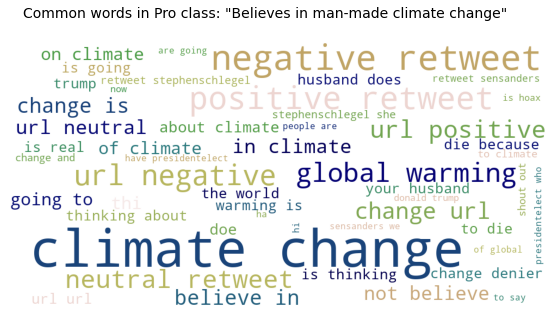

In [74]:
p= (' '.join(df_pro['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50,background_color="white",colormap="gist_earth").generate(p)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.figtext(.5,.9,'Common words in Pro class: "Believes in man-made climate change"\n',fontsize=14, ha='center')

plt.show()

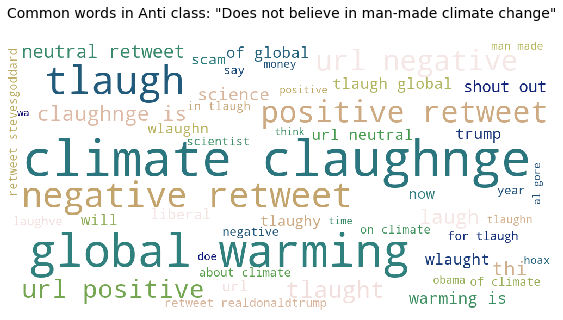

In [62]:
a= (' '.join(df_anti['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50,background_color="white",colormap="gist_earth").generate(a)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.figtext(.515,.9,'Common words in Anti class: "Does not believe in man-made climate change"\n',fontsize=14, ha='center')

plt.show()

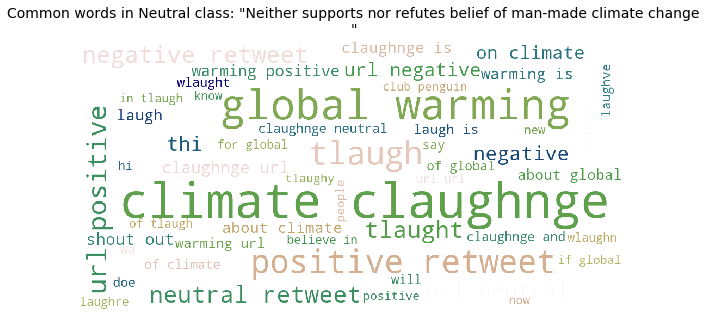

In [65]:
n= (' '.join(df_neutral['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50,background_color="white",colormap="gist_earth").generate(n)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.figtext(.515,.9,'Common words in Neutral class: "Neither supports nor refutes belief of man-made climate change\n"',fontsize=14, ha='center')

plt.show()

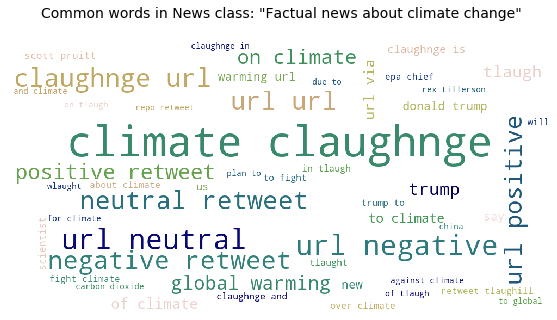

In [64]:
nw= (' '.join(df_news['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50,background_color="white",colormap="gist_earth").generate(nw)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.figtext(.515,.9,'Common words in News class: "Factual news about climate change"\n',fontsize=14, ha='center')

plt.show()

From these word clouds we can see some of the most common words that are used in tweets with the highest sentiment in each class.This gives us some sort of indication on the type of words a tweet with certain sentiment might have. For example, in our outputs above Pro class has words and phrases like *love*, *building new*, *new earth* and Anti has words and phrases like *die*, *doesn't believe*. 

Next we will look at the distribution of the sentiment scores to see the overall distribution of the sentiment in our tweets data 

In [66]:
#proportion of the negative positive and neutral sentiments.
df_analyse['comp_score'].replace({1:'positive',0:'neutral',-1:'negative'}).value_counts()/len(df_analyse)

neg    0.413827
pos    0.385335
neu    0.200838
Name: comp_score, dtype: float64

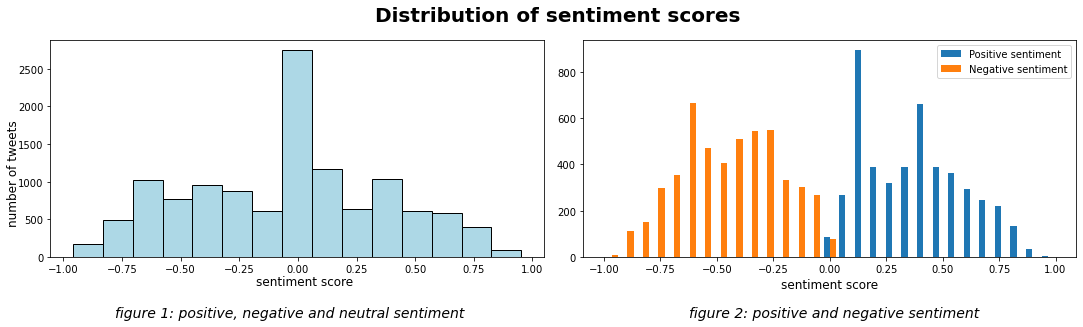

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 4))
plt.figtext(.51,.95, 'Distribution of sentiment scores\n', fontsize=20, ha='center',fontweight='bold')

ax1.hist(df_analyse['compound'], bins=15, edgecolor='k',color='lightblue')
plt.figtext(0.23, 0.06, 'sentiment score\n', horizontalalignment='left',fontsize = 12)
fig.text(0.00001, 0.5, 'number of tweets', va='center', rotation='vertical',fontsize=12)
plt.figtext(0.10, 0.0001, 'figure 1: positive, negative and neutral sentiment', horizontalalignment='left',fontsize = 14,style='italic')

bins = np.linspace(-1, 1, 30)
ax2.hist([df_analyse['compound'][df_analyse['compound'] > 0], df_analyse['compound'][df_analyse['compound'] < 0]], bins, label=['Positive sentiment', 'Negative sentiment'])
plt.xlabel('sentiment score\n',fontsize=12)
ax2.legend(loc='upper right')
plt.figtext(0.90, 0.0001, 'figure 2: positive and negative sentiment', horizontalalignment='right',fontsize = 14,style='italic')

plt.tight_layout()
plt.show()

In *figure 1* we can see that the data has a somewhat symmetric shape indicating uniformity in our data with a spike at 0(i.e neutral). The spike indicates that more data falls in that range, i.e most of our tweets were assigned a neutral sentiment. This makes sense since all the neutral data was packed into the 0 range,whereas the positive and negative sentiments where distributed in the ranges [-1:0) and (0:1], respectively

In *figure 2* we only look a the positive(right) and negative(left) sentiments. The positive sentiment has less tweets with sentiment greater that 0.5(i.e high positive sentiment), whereas negative sentiment has significantly more tweets below -0.5(i.e high negative sentiment).

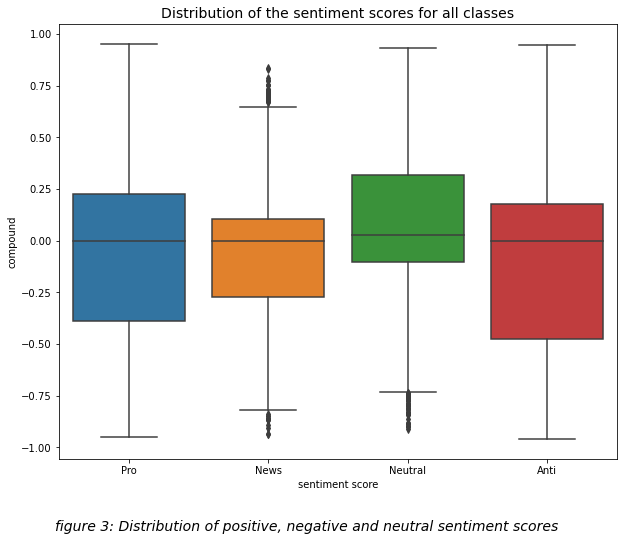

In [147]:
df_sent['sentiment'] = df_sent['sentiment'].replace({2:'News',1:'Pro',0:'Neutral',-1:'Anti'})
plt.figure(figsize=(10,8))
sns.boxplot(x='sentiment', y='compound' , data= df_sent)
plt.title('Distribution of the sentiment scores for all classes',fontsize = 14)
plt.xlabel('sentiment score', fontsize = 10)
plt.figtext(0.12, 0.00000001, 'figure 3: Distribution of positive, negative and neutral sentiment scores', horizontalalignment='left',
            fontsize = 14,style='italic')

plt.show()

Looking at the overall distribution of the sentiment score for the tweets data, *figure 3* shows a left skewed distribution. This is indicating that most of the tweets are scored with a negative sentiment. 

Next we will have a look at the different labels we will be classifying to. We know that our data is classified to four unique classes (*News*, *Pro*, *Neutral*, *Anti*). Let us have a look at the data associated with each class.

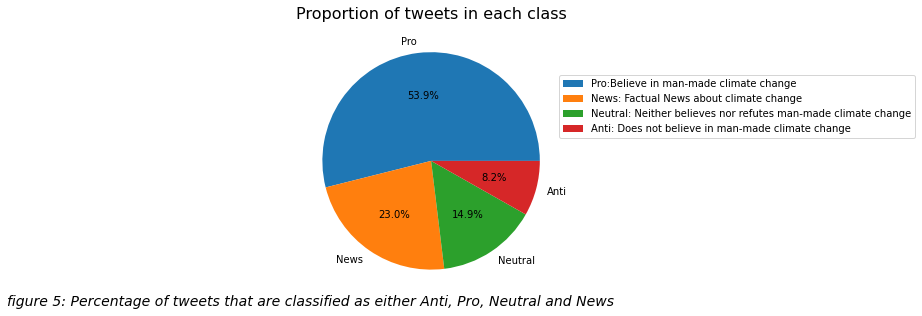

In [101]:
plt.figure(figsize=(15,5))
names = ['Pro','News','Neutral','Anti']
perc = df_train['sentiment'].replace({-1: 'Anti',0:'Neutral',1:'Pro',2:'News'}).value_counts()
perc.name = ''
perc.plot(kind='pie', labels=names, autopct='%1.1f%%')
plt.title('Proportion of tweets in each class',fontsize = 16)
plt.figtext(0.12, 0.1, 'figure 4: Percentage of tweets that are classified as either Anti, Pro, Neutral and News',
            horizontalalignment='left',fontsize = 14,style='italic')
plt.legend(df_train['sentiment'].replace({-1: 'Anti: Does not believe in man-made climate change',
                                          0:'Neutral: Neither believes nor refutes man-made climate change',
                                          1:'Pro:Believe in man-made climate change',
                                          2:'News: Factual News about climate change'}).value_counts().index,
           bbox_to_anchor=(2.3,0.7), loc="right")

plt.show()

Examining *figure 4* and *figure 5* it is apparent that the majority of the tweets(53.9%) are classified as Pro, i.e. supports the belief of man-made climate change, and the minority of the tweets(8.2%) are classified as Anti, i.e Does not believe in man made climate change. Tweets classified as Pro are 6.6 times more than those classified as AntiTweets classified as Pro are 6.6 times more than those classified as Anti. There is a signican imbalance between the two groups.
Unbalanced data is a problem, in that, the model might perform well in classifying the larger class but do poorly in classifying the smaller classes. So we can expect that the classification algorithm will perform better when classifying larger classes ( _Pro_ ) than the smaller classes ( _News, Neutral, Anti_ ). 
In our case knowing when a tweet has a sentiment that is Anti man-made climate change has an impact on how that customer may perceive a product. So if the model will mostly sentiment as Pro  man made climate change, it could classify some of the anti as pro which gives a skewed idea about customers.

To deal with unbalanced data one can apply resampling to the classes by adjusting the number of observations in the classes. There are 3 types of resampling:

    1.Upsampling: Taking repeated random samples from the minority class until we have as many observations as the majority           class. This duplicates observations in the minority class at random
    
    2.Downsampling: Taking a random subset of the majority class small enough to match the number of observations in the             minority class. This then reduces the number of observations in the majority class.
    
    3.Both: You can apply both of these resampling methods by deciding on a class_size(usually half of major class) and               setting a threshold of 50% where classes above this threshold are downsampled and classes below this threshold are             upsampled


We have then created a funtion To deal with the uneven distribution of class labels. The function will modify the number of observations for a class(es) we need to resample. 

In [72]:
# Create resampling function
def resampling(df, class1, class2):
    """ A function takes in a dataframe, a class to be resampled, and a class 
        thats observations are to be matched with.

        Parameters
        ----------
        df:     Dataframe to be resampled.
        class1: Integer of the class that is to be resampled.
        class2: Integer of the class whose length is used to resample class1.

        Returns
        -------
        df_resampled:  Resampled dataframe.
    """
    df_class1= df[df.sentiment==class1]
    df_class2 = df[df.sentiment==class2]
    df_new= df[df.sentiment!=class1]
    resampled = resample(df_class1, replace=False, n_samples=len(df_class2), random_state=27)
    df_resampled = pd.concat([resampled, df_new])    
    return df_resampled

**Having a look at the distribution of word counts per class**

In [135]:
df_sent['count'] = df_sent['message'].apply(lambda x: len(x.split()))

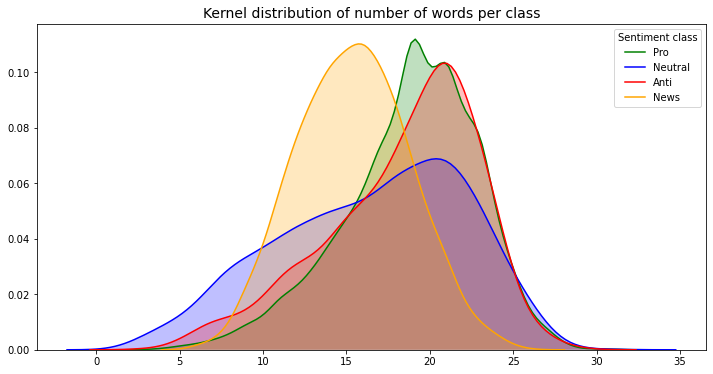

In [148]:
plt.figure(figsize=(12,6))
plt.title('Kernel distribution of number of words per class',fontsize = 14)
sns.kdeplot(df_sent['count'][df_sent['sentiment']=='Pro'], shade=True, color='g',legend=False)
sns.kdeplot(df_sent['count'][df_sent['sentiment']=='Neutral'], shade=True, color='b',legend=False)
sns.kdeplot(df_sent['count'][df_sent['sentiment']=='Anti'], shade=True, color='r',legend=False)
sns.kdeplot(df_sent['count'][df_sent['sentiment']=='News'], shade=True, color='orange',legend=False)
plt.legend(title='Sentiment class', loc='upper right', labels=['Pro', 'Neutral', 'Anti', 'News'])

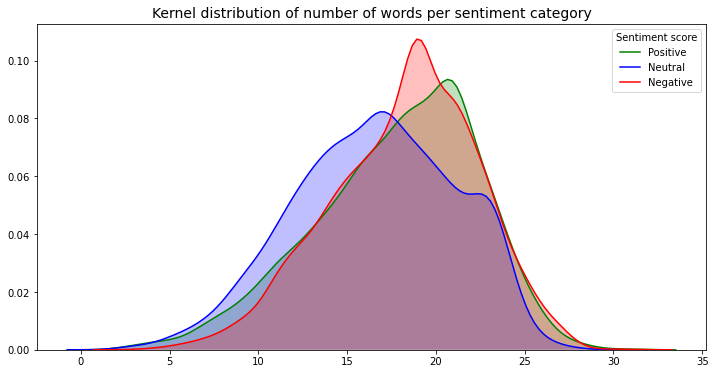

In [151]:
plt.figure(figsize=(12,6))
plt.title('Kernel distribution of number of words per sentiment category',fontsize = 14)
sns.kdeplot(df_sent['count'][df_sent['comp_score']=='pos'], shade=True, color='g',legend=False)
sns.kdeplot(df_sent['count'][df_sent['comp_score']=='neu'], shade=True, color='b',legend=False)
sns.kdeplot(df_sent['count'][df_sent['comp_score']=='neg'], shade=True, color='r',legend=False)
plt.legend(title='Sentiment score', loc='upper right', labels=['Positive', 'Neutral', 'Negative'])

??

In [207]:
# Pro tweets
vecp = CountVectorizer(stop_words='english')
count_vecp = vecp.fit_transform(df_sent['message'][df_sent['comp_score']=='pos'])
c_words_p = count_vecp.sum(axis=0) 
wordcountp = [(w, c_words_p[0, i]) for w, i in vecp.vocabulary_.items()]
wordcountp =sorted(wordcountp, key = lambda x: x[1], reverse=True)

pd.DataFrame(wordcountp[:10],columns=['Most common words','Count']).style.background_gradient(cmap='Greens')

,Most common words,Count
0,climate,3800
1,change,3663
2,rt,3328
3,https,3304
4,global,2252
5,warming,2199
6,trump,652
7,amp,355
8,real,342
9,believe,306


Finally we look at the ditribution of the labels

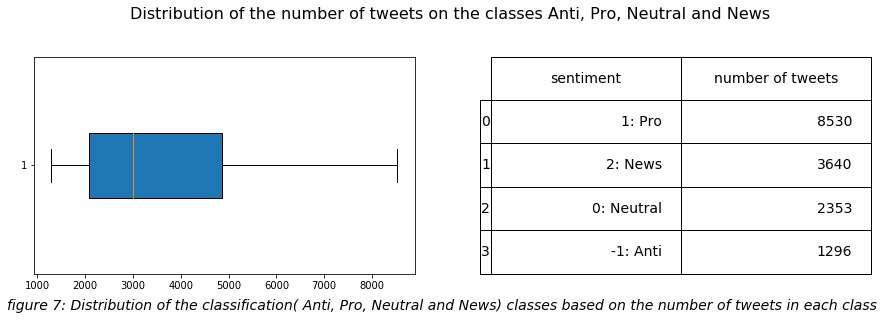

In [73]:
cnt = df_train['sentiment'].value_counts().rename_axis('sentiment').reset_index(name='number of tweets')
di = {-1: '-1: Anti',0:'0: Neutral',1:'1: Pro',2:'2: News'}
cnt['sentiment'].replace(di, inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 4))
plt.figtext(.51,.95, 'Distribution of the number of tweets on the classes Anti, Pro, Neutral and News\n', fontsize=16, ha='center')

ax1.boxplot(cnt['number of tweets'], widths = 0.3, vert=False, patch_artist=True)
plt.xlabel('Number of tweets per sentiment class')
# ax.set_xlabel('Number of tweets per sentiment class')
plt.yticks([1],[''])

font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = cnt.values, rowLabels = cnt.index, bbox=bbox, colLabels=cnt.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

plt.figtext(0.1, 0.0005, 'figure 6: Distribution of the classification( Anti, Pro, Neutral and News) classes based on the number of tweets in each class',
            horizontalalignment='left',
            fontsize = 14,style='italic')

plt.show()

*Figure 6* indicates a skewness to the right. This indicates further that the data consists of more Pro tweets than Anti tweets

## Split data into response and predictors

Next we split our data into response (Y) and predictor variables (X). We will use the predictor to fit a model that can somewhat accurately classify a tweet. The response variable will be used to validate/test our predictions. Our predictor variable would be our `message` column and our response variable would be what we want to predict, which is the `sentiment` column.

In [74]:
y = df_train['sentiment']
X = df_train['message']

## Split data into training and validation sets

The ultimate goal of fitting our machine learning models is to make relatively accurate classifications on unseen data. This is data we don't have at our disposal. So to measure the performance of our model we want to test it on unseen data as well. This is why we create a validation or testing set.  

- Training sets: The samples of data the model uses for learning  
- Testing sets: The samples of data used to assess the model's performance.

We chose to use 80% of the data for training and 20% was kept aside for validation. The observations for these datasets are selected at random. This ensures that the mix of data in the train set is as close as possible to the mix in the validation/test set.  

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature extraction

In this section we are going to transform our text data into something that the computer can understand and use for modeling.  

But first we will explore stopwords, n-grams and the impact they have on some baseline model. We chose logistic regression to evaluate the impact of these features on our overall model accuracy. This model was chosen due to it being scalable to large data and also being one of the more computationally efficient models.  

We start by extracting features from text data using `TfidfVectorizer()`. The tfidf vectorizer learns vocabulary from the text data and then proceeds to tokenize and create feature vectors from the text. Each tweet is then represented by a unique vector depending on its tokens, where the columns inside the vectors represent the features (which is the different words in the vocabulary) and the values represent the count of each word present in the tweet. See the illustration below.  

<img src="Vectorize1.png" style="width:800px;height:500px">

And voila! We have transformed text into a form that computers can understand. All these vectors are then transformed to contain tfidf(term frequency–inverse document frequency) scores instead of these counts. Tfidf is a numerical statistic that is intended to reflect how important a word is to a document (tweet in our case). It works by proportionally increasing to the number of times a word appears in a document (tweet), but is offset by the number of documents that contain the word. So words like 'you, 'this' and 'and' rank low even though they may appear many times. This is because they do not mean that much to the document. On the other hand, words like 'armadillo' would have a higher ranking since we assume that a word is very relevant to the given document if it does not appear in many other documents. 

Often in languages we have different versions of words that have the same core meaning. Examples would be 'run', 'ran' and 'running'. All three those word essentially refer to the action of running, just in different times. There is a method called stemming that reduces words to their base form. So essentially, after applying this method, all three of the words above would be reduced to the word 'run'. Python's nltk library has a method (`SnowballStemmer()`) that does exactly this for us. We will now write a class that will stem and tokenize text data and use this as a parameter in our vectorizer.

In [35]:
# Write class that has object that tokenizes text data AND stems the tokens
class StemAndTokenize:
    def __init__(self):
        self.ss = SnowballStemmer('english')
    def __call__(self, doc):
        return [self.ss.stem(t) for t in word_tokenize(doc)]

#### Stopwords  

First we'll look at stopwords using **unigrams**. Stopwords are common words that, due to their frequency in all sentences of any class, could be seen as insignificant. These are words like 'the', 'and', 'with', 'for', 'you' and 'I'. It is often assumed that removing stopwords improves a model's performance. But since tweets tend to be very short, with a maximum of only 280 characters, we want to test whether removing them could possibly reduce model accuracy instead.  

Let's create two different feature matrices, one containing stopwords and one with stopwords removed.

In [36]:
# Stopwords included
SW_vec_uni = TfidfVectorizer(tokenizer=StemAndTokenize())
SW_X_uni = SW_vec_uni.fit_transform(X_train)

# Stopwords excluded
noSW_vec_uni = TfidfVectorizer(stop_words='english', tokenizer=StemAndTokenize())
noSW_X_uni = noSW_vec_uni.fit_transform(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Next we fit a logistic regression model to both these feature matrices.

In [37]:
# Stopwords included
SW_uni = LogisticRegression()
SW_uni.fit(SW_X_uni,y_train)

# Stopwords excluded
noSW_uni = LogisticRegression()
noSW_uni.fit(noSW_X_uni,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Let's look at both the accuracy score and F1 score when using these trained models to predict the sentiment of tweets. Since our test set serves as our unseen data we do not fit the vectorizer to the test set, we only transform it with the vectorizer fit to the corresponding train set.

In [38]:
# Stopwords included
SW_uni_pred = SW_uni.predict(SW_vec_uni.transform(X_test))
print('====== Stopwords included ======')
print(f'Accuracy: {accuracy_score(y_test, SW_uni_pred)} \nF1-score: {f1_score(y_test, SW_uni_pred, average="weighted")}')
print()
print()

# Stopwords excluded
noSW_uni_pred = noSW_uni.predict(noSW_vec_uni.transform(X_test))
print('====== Stopwords excluded ======')
print(f'Accuracy: {accuracy_score(y_test, noSW_uni_pred)} \nF1-score: {f1_score(y_test, noSW_uni_pred, average="weighted")}')

====== Stopwords included ======
Accuracy: 0.7402022756005057 
F1-score: 0.7191664897915931


====== Stopwords excluded ======
Accuracy: 0.7354614412136536 
F1-score: 0.7123380136033697


Albeit a small difference, the model containing stopwords seems to perform better. This will probably be the case for other models as well. After optimizing hyperparameters later on, this difference could possibly be even larger. So we conclude that it would be wise to keep stopwords inside the text data. 

#### N-grams

Next we compare the model above with models that use bigrams and trigrams. N-grams are all possible combinations of adjacent words of length n in text (*or in our case a tweet*). Let us illustrate this using an example.  

> *Text:*  
`'The brown fox jumps over the gate'`  
***
> *List of bigrams (n-grams where n=2):*  
`['The brown', 'brown fox', 'fox jumps', 'jumps over', 'over the', 'the gate']`  

N-grams are used to capture the language structure of the text. They look at how likely it is for a letter or word to follow another one. The longer the n-gram (the larger the value of n), the more context you have to work with. N-grams are known to increase a model's accuracy, but generally we do not want n-grams to be too long, since they would start becoming counterproductive.  

Now we create two different feature matrices, one using bigrams and one using trigrams. Both of these models will **not** have stopwords removed.

In [39]:
# Bigrams
SW_vec_bi = TfidfVectorizer(tokenizer=StemAndTokenize(), ngram_range=(2, 2))
SW_X_bi = SW_vec_bi.fit_transform(X_train)

# Trigrams
SW_vec_tri = TfidfVectorizer(tokenizer=StemAndTokenize(), ngram_range=(3, 3))
SW_X_tri = SW_vec_tri.fit_transform(X_train)

Next we fit a logistic regression model to both these feature matrices.

In [40]:
# Bigrams
SW_bi = LogisticRegression()
SW_bi.fit(SW_X_bi,y_train)

# Trigrams
SW_tri = LogisticRegression()
SW_tri.fit(SW_X_tri,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Let's look at both the accuracy score and F1 score when using these trained models to predict the sentiment of tweets. We will add the unigram model here again for comparison.

In [41]:
# Unigrams
SW_uni_pred = SW_uni.predict(SW_vec_uni.transform(X_test))
print('========== Unigrams ==========')
print(f'Accuracy: {accuracy_score(y_test, SW_uni_pred)} \nF1-score: {f1_score(y_test, SW_uni_pred, average="weighted")}')
print()
print()
      
# Bigrams
SW_bi_pred = SW_bi.predict(SW_vec_bi.transform(X_test))
print('========== Bigrams ==========')
print(f'Accuracy: {accuracy_score(y_test, SW_bi_pred)} \nF1-score: {f1_score(y_test, SW_bi_pred, average="weighted")}')
print()
print()

# Trigrams
SW_tri_pred = SW_tri.predict(SW_vec_tri.transform(X_test))
print('========== Trigrams ==========')
print(f'Accuracy: {accuracy_score(y_test, SW_tri_pred)} \nF1-score: {f1_score(y_test, SW_tri_pred, average="weighted")}')

========== Unigrams ==========
Accuracy: 0.7402022756005057 
F1-score: 0.7191664897915931


========== Bigrams ==========
Accuracy: 0.7098609355246523 
F1-score: 0.6752124717719953


========== Trigrams ==========
Accuracy: 0.6665613147914032 
F1-score: 0.6192155186320547


From the output we see that the model using bigrams seems to outperform the model using trigrams. But overall the model using unigrams reigns supreme.  

So after examining the impact of both stopwords and n-grams we conclude that a model using unigrams and containing stopwords would be the better choice. We will use these parameter values for the vectorizers for all our models from this moment on.

### Build pipelines  

To reduce the amount of code we use, we will be using pipelines that will both vectorize the text data and create our different models. In the spirit of killing two birds with one stone, let's add another and add the method `GridSearchCV()` to the pipeline. This method is used to optimize some parameters for each of the models we want to train. And we will be using cross validation to determine the best combination of parameters. An explanation will follow, but this image describes it nicely:  

<img src="cv.png" style="width:800px;height:500px">

According to an [article](https://machinelearningmastery.com/k-fold-cross-validation/#:~:text=Cross%2Dvalidation%20is%20a%20resampling,k%2Dfold%20cross%2Dvalidation.) by Machine Learning Mastery, cross-validation is a statistical method used to estimate the skill of machine learning models. We have already split our data into training and testing sets, but here we will do another split on our training set. As we can see from the image above, a certain percentage (we chose 10%) of the training data will be kept aside for validation purposes. We essentially train the model on 90% of the train set and using the rest of the 10% to calculate some accuracy statistic of our choice. This process is then repeated a number of times and in our case we are choosing a 10 fold split. Each repeat will have a different combination of the train set for training and validation. And finally we aggregate over all the statistics for our final accuracy statistic. 

The parameters that will be optimized, however, will differ from model to model, but we'll discuss our choices further below.

**Logistic Regression**

The first model we're going to look at is Logistic regression. For this model and all the following models, we are using 10-fold crossvalidation (`cv=10`) and specifying the parameter `n_jobs=-1` so we can use all processors when applying the gridsearch method. In some cases we will also be setting `random_state=42` so we can compare the performance of our different models.  

For logistic regression we are only going to look at the C parameter. It’s a penalty term, meant to disincentivize and regulate against overfitting. The parameter indicates the inverse of regularization strength, i.e. smaller values specify stronger regularization. So we will be looking which size of C yields the best results. 

*Hyperparameter optimization:*

In [42]:
# parameters to be tested for Logistic Regression
param_grid_lr = {'C':[0.01, 0.1, 1, 5, 10, 20]}

*Pipeline:*

In [43]:
# Create pipeline for Logistic Regression:
lr = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('lr', GridSearchCV(LogisticRegression(),
                                   param_grid=param_grid_lr,
                                   cv=10,
                                   n_jobs=-1))
              ])

**Naïve Bayes**

For the naïve bayes classifier we will also only be looking at one parameter. `alpha` is the regularization parameter for the naïve bayes classifier and is known as the smoothing parameter.  

*Hyperparameter optimization:*

In [44]:
# parameters to be tested for Naïve Bayes
param_grid_nb = {'alpha':[0.001, 0.01, 0.1, 1, 5]}

*Pipeline:*

In [45]:
# Create pipeline for Naïve Bayes:
nb = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('nb', GridSearchCV(MultinomialNB(),
                                   param_grid=param_grid_nb,
                                   cv=10,
                                   n_jobs=-1))
              ])

**SVM (Support Vector Machine)**

For support vector machines we will be trying to optimize three parameters. Once again we'll have a look at the C parameter we explained above, along with the `kernel` and `gamma` parameters. Kernel methods are a class of algorithms used to detect and study patterns in data. We'll look at the linear kernel as well as the radial basis function (rbf) kernel. The `gamma` parameter indicates the kernel coefficient for the rbf kernel and we'll look at the options 'scale' and 'auto'.

*Hyperparameter optimization:*

In [46]:
# parameters to be tested for SVM
param_grid_svm = {'C':[50, 100, 150, 200],
                  'kernel':['linear', 'rbf'],
                  'gamma':['scale','auto']}

*Pipeline:*

In [47]:
# Create pipeline for SVM:
svm = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('svm', GridSearchCV(SVC(random_state=42),
                                   param_grid=param_grid_svm,
                                   cv=10,
                                   n_jobs=-1))
              ])

**Random Forest**

For the random forest classifier we will be looking at four different parameter. `max_features` indicates the maximum number of features to consider when looking for the best split. By reducing the number of features each tree in a random forest can use to fit a model, we improve the model. This is simply due to the model now being able to test a lot of different combinations of variables, rather than fitting a model using all the features every time. `n_estimators` indicate the number of trees that we want in the forest and `max_depth` indicate the maximum depth of a single tree. And finally we also look at `criterion` which indicates the function to be used to measure the quality of a split.  

*Hyperparameter optimization:*

In [55]:
# parameters to be tested for Random Forest
param_grid_rf = {'max_features':[0.5,'log2'],
                 'n_estimators':[50,75,100],
                 'criterion':['gini','entropy'],
                 'max_depth':[10,15,None]}

*Pipeline:*

In [56]:
# Create pipeline for Random Forest:
rf = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('rf', GridSearchCV(RandomForestClassifier(random_state=42),
                                   param_grid=param_grid_rf,
                                   cv=10,
                                   n_jobs=-1))
              ],verbose=True)

**KNN (K Nearest Neighbors)**

The only parameter we are going to look at for the KNN model is `n_neighbors`, which indicates number of neighbors to use.  

*Hyperparameter optimization:*

In [50]:
# parameters to be tested for KNN
param_grid_knn = {'n_neighbors':[3,5,10,15,20,50,100]}

*Pipeline:*

In [51]:
# Create pipeline for KNN:
knn = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('knn', GridSearchCV(KNeighborsClassifier(weights='distance'),
                                    param_grid=param_grid_knn,
                                    cv=10,
                                    n_jobs=-1))
              ])

**Neural Networks**

For our neural networks we are going to look at the methods used for our activation function. When discussing neural networks later on, we'll go into a bit more detail on what an activation function is and how these different methods work.  

*Hyperparameter optimization:*

In [52]:
# parameters to be tested for Neural Networks
param_grid_nn = {'activation':['logistic','tanh','relu']}

*Pipeline:*

In [53]:
# Create pipeline for Neural Networks:
nn = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('nn', GridSearchCV(MLPClassifier(batch_size=100,random_state=42,verbose=True,early_stopping=True),
                                   param_grid=param_grid_nn,
                                   cv=10,
                                   n_jobs=-1))
              ])

## Train models

Before we can classify any new tweets we have to train a model using past tweets so the model can learn how to classify tweets into their respective classes. We will look into 6 classification models to train: `Logistic Regression`, `Naive Bayes`, `Support Vector Machine`, `Random Forest`, `K Nearest Neighbours` and `Neural Networks`.  

_**NOTE:** After applying the gridsearch method above the following blocks of code will train longer than usual to find the optimal combination of hyperparameters. Patience is key._

**Logistic Regression**

In [51]:
# Fitting the Logistic Regression model
lr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='war

In [75]:
best_param_lr = lr['lr'].best_params_
print(best_param_lr)

{'C': 5, 'class_weight': None}


**Naïve Bayes**

In [61]:
# Fitting the Naïve Bayes model
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=<__main__.StemAndTokenize object at 0x0F55A510>,
                                 use_idf=True, vocabulary=None)),
                ('nb',
                 GridSearchCV(cv=10, error_score='raise-deprecating',
                              estimator=Multinomial

In [76]:
best_param_nb = nb['nb'].best_params_
print(best_param_nb)

{'alpha': 0.1}


**SVM (Support Vector Machine)**

In [63]:
# Fitting the SVM model
svm.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False, random_state=42,
                                            shrinking=True, tol=0.001,
 

In [77]:
best_param_svm = svm['svm'].best_params_
print(best_param_svm)

{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


**Random Forest**

In [57]:
# Fitting the Random Forest model
rf.fit(X_train, y_train)

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=  10.9s
[Pipeline] ............... (step 2 of 2) Processing rf, total=498.3min


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                                               n_estimators='warn',
                                                               n_jobs=None,
                                                               oob_score=False,
                                                              

In [58]:
best_param_rf = rf['rf'].best_params_
print(best_param_rf)

{'criterion': 'gini', 'max_depth': 15, 'max_features': 0.5, 'n_estimators': 75}


**KNN (K Nearest Neighbors)**

In [77]:
# Fitting the KNN model
knn.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.StemAndTokenize object at 0x119E3DF0>,
                                 use_idf=True, vocabulary=None)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                             

In [ ]:
print(knn['knn'].best_params_)

**Neural Networks**

In [78]:
# Fitting the Neural Networks model
nn.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\ProgramData\Anaconda3\lib\site-packages\

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rat

In [ ]:
print(nn['nn'].best_params_)

## Make predictions

The ultimate goal of training a classification model is to be able to classify new instances or new data. So next we make new classifications for new data(test dataset).

**Logistic Regression**

In [65]:
# Form a prediction set for the Logistic Regression model
pred_lr = lr.predict(X_test)

**Naïve Bayes**

In [66]:
# Form a prediction set for the Naïve Bayes model
pred_nb = nb.predict(X_test)

**SVM (Support Vector Machine)**

In [67]:
# Form a prediction set for the Linear SVM model
pred_svm = svm.predict(X_test)

**Random Forest**

In [82]:
# Form a prediction set for the Random Forest model
pred_rf = rf.predict(X_test)

**KNN (K Nearest Neighbors)**

In [ ]:
# Form a prediction set for the KNN model
pred_knn = knn.predict(X_test)

**Neural Networks**

In [84]:
# Form a prediction set for the Neural Network model
pred_nn = nn.predict(X_test)

## Evaluate model accuracy

### Confusion matrices

A [confusion matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62) is performance metric used in a machine learning classification problem where the output can be two or more classes. It is a table with 4 different combinations of predicted and actual values. Each block in the table is a number of those classifications made 

The table consists of 4 measures that form part of the confusion matrix:
      
- **TP(True Positive)** : You predicted positive and it’s true. Number of correctly classified positives
- **FP(False Positive)** : You predicted positive and it’s false. Number of incorrectly classified positives
- **FN(Falso Negative)** : You predicted negative and it’s false. Number of incorrectly classified negatives
- **TN(True Negative)** :  You predicted negative and it’s true. Number of correctly classified negatives

![confusionmatrix.png](confusionmatrix.png)

In [137]:
labels = ['2: News', '1: Pro', '0: Neutral', '-1: Anti']

**Logistic Regression**

In [138]:
pd.DataFrame(data=confusion_matrix(y_test, pred_lr), index=labels, columns=labels)

,2: News,1: Pro,0: Neutral,-1: Anti
2: News,122,30,115,11
1: Pro,18,179,201,27
0: Neutral,26,97,1501,131
-1: Anti,5,13,131,557


**Naïve Bayes**

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_nb), index=labels, columns=labels)

**SVM (Support Vector Machine)**

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_svm), index=labels, columns=labels)

**Random Forest**

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_rf), index=labels, columns=labels)

**KNN (K Nearest Neighbors)**

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_knn), index=labels, columns=labels)

**Neural Networks**

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_nn), index=labels, columns=labels)

### Classification report

A [classification report](https://muthu.co/understanding-the-classification-report-in-sklearn/) measure the quality of the predictions made by a classification algorithm. it indicates how many predictions are True and how many are False. The report also uses the True Positives(TP), False Positives(FP), True Negatives(TN) and False Negatives(FN) to show the main classification metrics,i.e precision, recall and f1-score on a per-class basis.  These are the same concepts used in the confusion matrix above.

**Precision** : The ability of a classifier to not label an instance positive when it is actually negative. So it considers how                  accurate a classifier is in predicting positive cases.
                 For each class it is defined as the ratio of true positives to the sum of true and false positives:
               
                precision = TP/(TP + FP)
               
**Recall** : The ability of a classifier to find all positive instances. It considers the fraction of positives that were                     correctly identified.
             For each class it is defined as the ratio of true positives to the sum of true positives and false negatives:
              
              recall = TP/(TP + FN)
              
**F1 Score** : A weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. As a rule                 of thumb, the weighted average of F1 should be used to compare classifier models

                F1 Score = 2*(Recall * Precision) / (Recall + Precision)

**Logistic Regression**

In [68]:
print('\033[1m Classification Report from Logistic Regression Model \033[0m \n')
print(classification_report(y_test, pred_lr, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

 Classification Report from Logistic Regression Model  

              precision    recall  f1-score   support

     2: News       0.75      0.44      0.55       278
      1: Pro       0.60      0.44      0.51       425
  0: Neutral       0.78      0.87      0.82      1755
    -1: Anti       0.78      0.79      0.79       706

    accuracy                           0.76      3164
   macro avg       0.73      0.64      0.67      3164
weighted avg       0.75      0.76      0.75      3164



**Naïve Bayes**

In [69]:
print('\033[1m Classification Report from Naïve Model \033[0m \n')
print(classification_report(y_test, pred_nb, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

 Classification Report from Naïve Model  

              precision    recall  f1-score   support

     2: News       0.93      0.31      0.47       278
      1: Pro       0.60      0.23      0.33       425
  0: Neutral       0.71      0.92      0.80      1755
    -1: Anti       0.80      0.72      0.75       706

    accuracy                           0.73      3164
   macro avg       0.76      0.54      0.59      3164
weighted avg       0.73      0.73      0.70      3164



**SVM (Support Vector Machine)**

In [70]:
print('\033[1m Classification Report from SVM (Support Vector Machine) Model \033[0m \n')
print(classification_report(y_test, pred_svm, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

 Classification Report from SVM (Support Vector Machine) Model  

              precision    recall  f1-score   support

     2: News       0.80      0.44      0.57       278
      1: Pro       0.68      0.44      0.53       425
  0: Neutral       0.78      0.90      0.83      1755
    -1: Anti       0.81      0.81      0.81       706

    accuracy                           0.78      3164
   macro avg       0.77      0.65      0.69      3164
weighted avg       0.77      0.78      0.76      3164



**Random Forest**

In [90]:
print('\033[1m Classification Report from Random Forest Model \033[0m \n')
print(classification_report(y_test, pred_rf, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

Classification Report from Random Forest Model
              precision    recall  f1-score   support

     2: News       0.70      0.27      0.39       278
      1: Pro       0.52      0.38      0.44       425
  0: Neutral       0.71      0.86      0.78      1755
    -1: Anti       0.73      0.64      0.68       706

    accuracy                           0.69      3164
   macro avg       0.66      0.54      0.57      3164
weighted avg       0.69      0.69      0.67      3164



**KNN (K Nearest Neighbors)**

In [ ]:
print('\033[1m Classification Report from KNN(K Nearest Neighbours) Model \033[0m \n')
print(classification_report(y_test, pred_knn, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

**Neural Networks**

In [91]:
print('\033[1m Classification Report from Neural Networks Model \033[0m \n')
print(classification_report(y_test, pred_nn, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

Classification Report from Neural Networks Model
              precision    recall  f1-score   support

     2: News       0.65      0.48      0.55       278
      1: Pro       0.49      0.45      0.47       425
  0: Neutral       0.78      0.82      0.80      1755
    -1: Anti       0.76      0.77      0.76       706

    accuracy                           0.73      3164
   macro avg       0.67      0.63      0.65      3164
weighted avg       0.72      0.73      0.72      3164



The `F1 score` is our main metric that we use to decide on the best model to use. Below is a dataframe that shows the models with their respective F1 scores from largest score i.e best model, to lowest score i.e poor model

In [ ]:
F1_dict = {'Model':['Logistic Regression','Naïve Bayes','Linear SVM','Random Forest','KNN','Neural Network'],
        'F1_score' :[f1_score(y_test, pred_lr),
       f1_score(y_test, pred_nb),
       f1_score(y_test, pred_svm)
       f1_score(y_test, pred_rf),
       f1_score(y_test, pred_knn),
       f1_score(y_test, pred_nn)]}
# data = sorted(data.items(), key = lambda x: x[1], reverse = True) #sorting dictionary by values

F1_score = pd.DataFrame(data=F1_dict, columns=['Model F1_score'])
F1_score.sort_values("F1_score", axis = 0, ascending = False, inplace = True) 

## Saving important data 

### Save the models

In [71]:
# Logistic regression
with open('Logistic_regression.pkl','wb') as file:
    pickle.dump(lr,file)
    
# Naïve Bayes
with open('Naive_bayes.pkl','wb') as file:
    pickle.dump(nb,file)
    
# SVM
with open('SVM.pkl','wb') as file:
    pickle.dump(svm,file)
    
# Random Forest
with open('Random_forest.pkl','wb') as file:
    pickle.dump(rf,file)
    
# KNN
with open('KNN.pkl','wb') as file:
    pickle.dump(knn,file)
    
# Neural Network
with open('Neural_network.pkl','wb') as file:
    pickle.dump(nn,file)

### Save the optimal parameters

In [78]:
# Logistic regression
with open('best_param_dict_lr.pkl','wb') as file:
    pickle.dump(best_param_lr,file)
    
# Naïve Bayes
with open('best_param_dict_nb.pkl','wb') as file:
    pickle.dump(best_param_nb,file)
    
# SVM
with open('best_param_dict_svm.pkl','wb') as file:
    pickle.dump(best_param_svm,file)
    
# Random Forest
with open('best_param_dict_rf.pkl','wb') as file:
    pickle.dump(best_param_rf,file)
    
# KNN
with open('best_param_dict_knn.pkl','wb') as file:
    pickle.dump(best_param_knn,file)
    
# Neural Network
with open('best_param_dict_nn.pkl','wb') as file:
    pickle.dump(best_param_nn,file)

### Save the graphs

In [12]:
with open('Pie_chart.pkl','wb') as file:
    pickle.dump(plot3,file)
    
with open('Common_words_pro.pkl','wb') as file:
    pickle.dump(plot_wpro,file)
    
with open('Common_words_anti.pkl','wb') as file:
    pickle.dump(plot_wanti,file)
    
with open('Common_words_neutral.pkl','wb') as file:
    pickle.dump(plot_wneut,file)
    
with open('Common_words_news.pkl','wb') as file:
    pickle.dump(plot_wnews,file)

## Produce output

In [ ]:
# Make predictions
predictions = svm.predict(df_test['message']).reshape(-1, 1)
Id = np.array(df_test.index).reshape(-1, 1)
names = ['tweetid', 'sentiment']

# Create output dataframe
out = pd.DataFrame(np.append(Id,predictions, axis=1), columns=names)

In [ ]:
# Output to csv file
out.to_csv('output.csv',index=False)

## Log parameters

In [ ]:
f1 = f1_score(y_test, pred_Lsvm, average='weighted')
recall = recall_score(y_test, pred_Lsvm, average='weighted')
precision = precision_score(y_test, pred_Lsvm, average='weighted')
accuracy = accuracy_score(y_test, pred_Lsvm)
confusion_mat = confusion_matrix(y_test, pred_Lsvm)

In [ ]:
#these will be logged to your sklearn-demos project on Comet.ml
# (FINAL MODEL after gridsearch best parms)
params={"random_state":42,
        "test_size":0.2
        "model_type":"Linear SVM"
       }

metrics = {"f1":f1,
           "recall":recall,
           "precision":precision,
           "accuracy":accuracy
            }

# exp.log_dataset_hash(X_train_scaled)
exp.log_parameters(params)
exp.log_metrics(metrics)

experiment.log_confusion_matrix(labels=['2: News', '1: Pro', '0: Neutral', '-1: Anti'],matrix=confusion_mat)

experiment.log_figure(figure=plot1,figure_name='Distribution graph for different classes')
experiment.log_figure(figure=plot2,figure_name='Number of types of comments')

experiment.log_model(name='Linear SVM - base model', file_or_folder='pickled file')

## End experiment

In [ ]:
# experiment.end()

## Conclusion